# AED Taper Analysis (Using AD Ratios)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, math, pickle
from numpy import hanning
from scipy.fftpack import fft
from scipy.signal import iirnotch, filtfilt
from ieeg_utils import *

TABLES_DIRECTORY = "../../Data/giant_tables"
IEEG_DIRECTORY = "../../Data/ieeg/all/2_min"
OUTPUT_DIRECTORY = "../../Data/aed_taper_criticality"

TAPER_THRESHOLD = 0.5

In [2]:
patient_hup_ids = []
# Iterate through all files in TABLES_DIRECTORY
for filename in os.listdir(TABLES_DIRECTORY):
    # Only look at filename that are .csv files and does not begin with .
    if filename.endswith(".csv") and not filename.startswith("."):
        # Get the patient_hup_id from the filename which is after _ and before .
        patient_hup_id = str(filename.split("_")[1].split(".")[0])
        patient_hup_ids.append(patient_hup_id)

patient_hup_ids = [210, 165, 153]
patient_hup_ids = sorted(patient_hup_ids)
len(patient_hup_ids)

3

In [3]:
# Create an empty dictionary to store all the data
data_dict = {"dataset_name": [], "max_hour": [], "sample_rate": [], "hup_id": []}

# Iterate through the directory
for filename in os.listdir(IEEG_DIRECTORY):
    if filename.endswith(".pkl"):  # Only process .pkl files
        # Split the filename to get the dataset_name, hour, and sample_rate
        parts = filename.split("_")
        dataset_name = "_".join(parts[:-4])  # Exclude the '_hr' from the dataset_name
        hour = int(parts[-3])
        sample_rate = int(parts[-1].split(".")[0])

        # Extract hup_id from dataset_name
        hup_id = dataset_name.split("_")[0].split("HUP")[1]

        # If the dataset_name is already in the dictionary, update the max_hour
        if dataset_name in data_dict["dataset_name"]:
            index = data_dict["dataset_name"].index(dataset_name)
            data_dict["max_hour"][index] = max(data_dict["max_hour"][index], hour)
        else:
            # Else, add the dataset_name, hour, sample_rate and hup_id to the dictionary
            data_dict["dataset_name"].append(dataset_name)
            data_dict["max_hour"].append(hour)
            data_dict["sample_rate"].append(sample_rate)
            data_dict["hup_id"].append(hup_id)

# Create a DataFrame from the dictionary
datasets_df = pd.DataFrame(data_dict)
# Make max_hour and sample_rate and hup_id integers
datasets_df["max_hour"] = datasets_df["max_hour"].astype(int)
datasets_df["sample_rate"] = datasets_df["sample_rate"].astype(int)
datasets_df["hup_id"] = datasets_df["hup_id"].astype(int)
# Sort by hup_id
datasets_df = datasets_df.sort_values(by=["hup_id"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# Create a column called max_hour_count that is the max_hour + 1
datasets_df["max_hour_count"] = datasets_df["max_hour"] + 1
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP138_phaseII,172,1024,138,173
1,HUP140_phaseII_D02,128,1024,140,129
2,HUP140_phaseII_D01,19,1024,140,20
3,HUP141_phaseII,146,512,141,147
4,HUP142_phaseII,311,512,142,312
...,...,...,...,...,...
81,HUP215_phaseII_D01,14,2048,215,15
82,HUP216_phaseII_D01,143,512,216,144
83,HUP216_phaseII_D02,144,512,216,145
84,HUP223_phaseII,135,1024,223,136


In [4]:
# Only keep the datasets that are in the patient_hup_ids
datasets_df = datasets_df[datasets_df["hup_id"].isin(patient_hup_ids)]
# Sort by hup_id then by dataset_name
datasets_df = datasets_df.sort_values(by=["hup_id", "dataset_name"])
# Reset the index
datasets_df = datasets_df.reset_index(drop=True)
# Drop the row with dataset_name = HUP153_phaseII_D02
datasets_df = datasets_df.drop(
    datasets_df[datasets_df["dataset_name"] == "HUP153_phaseII_D02"].index
)
datasets_df

,dataset_name,max_hour,sample_rate,hup_id,max_hour_count
0,HUP153_phaseII_D01,166,512,153,167
2,HUP165_phaseII,459,1024,165,460
3,HUP210_phaseII,260,1024,210,261


## Helper functions

In [5]:
def find_taper_periods(hourly_patient_features_df):
    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[
        hourly_patient_features_df.awake != 0
    ]

    # Find the first emu_hour where num_seizures is greater than 0
    first_seizure = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] > 0
    ].emu_hour.min()

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[
        hourly_patient_features_df["num_seizures"] > 0
    ].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Make sure all rows to drop are within dataframe index range
    drop_rows = [row for row in drop_rows if row in hourly_patient_features_df.index]
    hourly_patient_features_df = hourly_patient_features_df.drop(drop_rows)

    # Find the first 'emu_hour' where both 'teager_energy' and 'kuramoto' are not nan
    start_point = hourly_patient_features_df[
        (~hourly_patient_features_df["teager_energy"].isna())
        & (~hourly_patient_features_df["kuramoto"].isna())
    ].emu_hour.min()

    # Get medication columns
    med_columns = [
        col for col in hourly_patient_features_df.columns if col.startswith("med_")
    ]

    # Find the peak values of each medication within the first 24 'emu_hour' starting from 'start_point'
    peak_values = hourly_patient_features_df[
        (hourly_patient_features_df["emu_hour"] >= start_point)
        & (hourly_patient_features_df["emu_hour"] < start_point + 24)
    ][med_columns].max()

    # Search for the first 'emu_hour' for which at least one medication drops below 40% of its corresponding peak value
    taper_start = hourly_patient_features_df[
        (hourly_patient_features_df["emu_hour"] >= start_point + 24)
        & (hourly_patient_features_df[med_columns] < peak_values * TAPER_THRESHOLD).any(
            axis=1
        )
    ].emu_hour.min()

    # Search for the first 'emu_hour' after 'taper_start + 24 + 48' where at least one medication starts to increase
    taper_end = (
        hourly_patient_features_df[
            hourly_patient_features_df["emu_hour"] > taper_start + 24 + 48
        ]
        .loc[
            hourly_patient_features_df[med_columns].diff().gt(0).any(axis=1), "emu_hour"
        ]
        .min()
    )

    # set taper_end to the minimum of taper_end and first_seizure
    taper_end = min(taper_end, first_seizure)

    return taper_start, taper_end

In [6]:
def plot_stuff(hourly_patient_features_df, taper_start, taper_end):
    med_cols = [
        col
        for col in hourly_patient_features_df.columns
        if col.startswith("med_") and not hourly_patient_features_df[col].eq(0).all()
    ]
    med_cols_no_raw = [col.split("_raw")[0] for col in med_cols]

    fig, ax = plt.subplots(6, 1, figsize=(10, 10), sharex=True)

    for i, col in enumerate(med_cols):
        if col != "med_sum_no_lorazepam_raw":
            label = med_cols_no_raw[i].replace("med_", "")
            normalized_data = (
                hourly_patient_features_df[col] / hourly_patient_features_df[col].max()
            )
            ax[0].plot(
                hourly_patient_features_df["emu_hour"], normalized_data, label=label
            )

    # Adding horizontal bars
    ax[0].hlines(1, taper_start, taper_end, color="orange", linewidth=2)

    # Adding text annotations
    ax[0].text(
        (taper_start + taper_end) / 2,
        1,
        "taper transition",
        ha="center",
        va="bottom",
    )

    # awake_hours = hourly_patient_features_df[hourly_patient_features_df["awake"] == 1][
    #     "emu_hour"
    # ].values
    # for idx in awake_hours:
    #     ax[0].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)

    seizure_hours = hourly_patient_features_df[
        hourly_patient_features_df["num_seizures"] >= 1
    ]["emu_hour"].values
    for idx in seizure_hours:
        ax[0].axvline(x=idx, color="red", linestyle="dotted")

    ax[0].set_ylabel("Normalized Load")
    # set y min and max to be 0 and 1.3
    ax[0].set_ylim([0, 1.3])
    ax[0].legend()
    ax[0].set_title("Individial AEDs")

    # New subplot for "med_sum_no_lorazepam_raw" titled as "Total AED"
    ax[1].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["med_sum_no_lorazepam_raw"],
    )
    ax[1].set_ylabel("Total AED")
    ax[1].set_title("Total AED")

    ax[2].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_all"],
    )
    # for idx in awake_hours:
    #     ax[2].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[2].axvline(x=idx, color="red", linestyle="dotted")

    ax[2].set_ylabel("Total Spikes")
    ax[2].set_title("All Spikes")

    ax[3].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["spikes_sum_soz"],
    )
    # for idx in awake_hours:
    #     ax[3].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[3].axvline(x=idx, color="red", linestyle="dotted")

    ax[3].set_ylabel("Total Spikes")
    ax[3].set_title("SOZ Spikes")

    ax[4].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["teager_energy"],
    )
    # for idx in awake_hours:
    #     ax[4].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[4].axvline(x=idx, color="red", linestyle="dotted")

    ax[4].set_ylabel("Teager Energy")
    ax[4].set_title("Teager Energy (Delta Band)")

    ax[5].plot(
        hourly_patient_features_df["emu_hour"],
        hourly_patient_features_df["kuramoto"],
    )
    # for idx in awake_hours:
    #     ax[5].axvspan(idx, idx + 1, facecolor="yellow", alpha=0.5)
    for idx in seizure_hours:
        ax[5].axvline(x=idx, color="red", linestyle="dotted")

    ax[5].set_ylabel("R")
    ax[5].set_title("Kuramoto Order Parameter (Delta Band)")

    ax[5].set_xlabel("Time (hours)")

    # max_hour = np.max(hourly_patient_features_df["emu_hour"])
    # ax[5].set_xticks(range(0, max_hour + 1, 24))
    # ax[5].set_xticklabels(
    #     ["Day " + str(i // 24 + 1) for i in range(0, max_hour + 1, 24)]
    # )

    plt.tight_layout()
    plt.show()

## Plot all time series

Processing patient 153
Patient 153 taper transition period: 91 - 138 = 47 hours


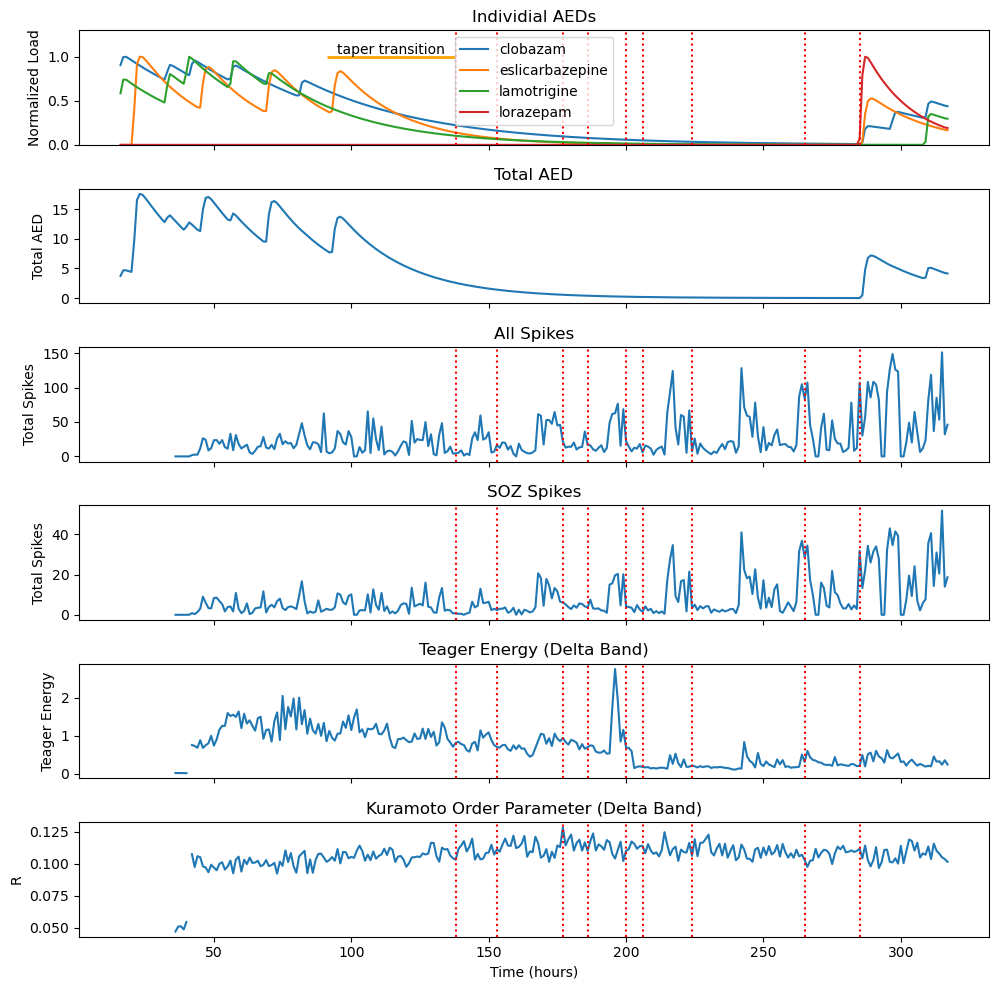

Processing hour 91
Processing electrode LA01
Processing electrode LA02
Processing electrode LA03
Processing electrode LA04
Processing electrode LA05
Processing electrode LA06
Processing electrode LA07
Processing electrode LA08
Processing electrode LB01
Processing electrode LB02
Processing electrode LB03
Processing electrode LB04
Processing electrode LB05
Processing electrode LB06
Processing electrode LB07
Processing electrode LB08
Processing electrode LC01
Processing electrode LC10
Processing electrode LC11
Processing electrode LC12
Processing electrode LC02
Processing electrode LC03
Processing electrode LC04
Processing electrode LC05
Processing electrode LC06
Processing electrode LC07
Processing electrode LC08
Processing electrode LC09
Processing electrode LD01
Processing electrode LD10
Processing electrode LD11
Processing electrode LD12
Processing electrode LD02
Processing electrode LD03
Processing electrode LD04
Processing electrode LD05
Processing electrode LD06
Processing electrod

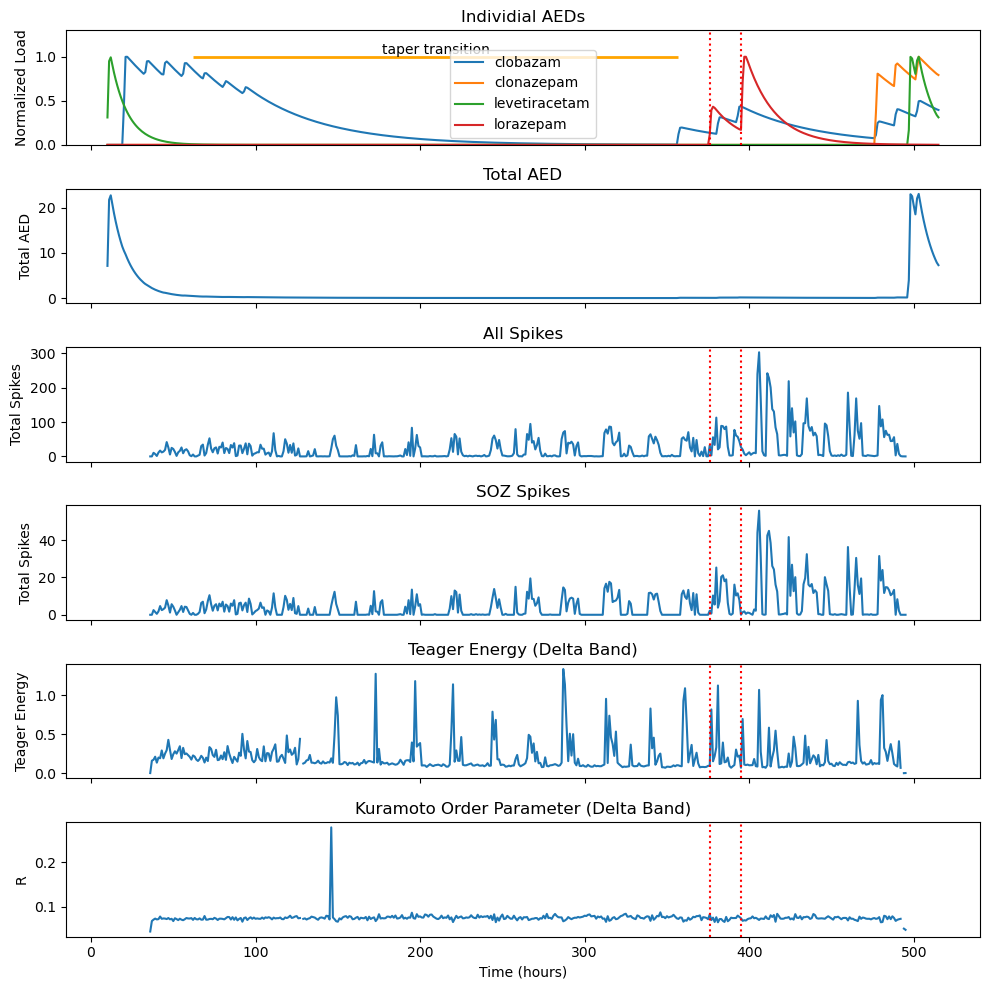

Processing hour 62
Processing electrode LA01
Processing electrode LA10
Processing electrode LA11
Processing electrode LA12
Processing electrode LA02
Processing electrode LA03
Processing electrode LA04
Processing electrode LA05
Processing electrode LA06
Processing electrode LA07
Processing electrode LA08
Processing electrode LA09
Processing electrode LB01
Processing electrode LB10
Processing electrode LB11
Processing electrode LB12
Processing electrode LB02
Processing electrode LB03
Processing electrode LB04
Processing electrode LB05
Processing electrode LB06
Processing electrode LB07
Processing electrode LB08
Processing electrode LB09
Processing electrode LC01
Processing electrode LC10
Processing electrode LC11
Processing electrode LC12
Processing electrode LC02
Processing electrode LC03
Processing electrode LC04
Processing electrode LC05
Processing electrode LC06
Processing electrode LC07
Processing electrode LC08
Processing electrode LC09
Processing electrode LD01
Processing electrod

KeyboardInterrupt: 

In [7]:
# Frequency range of interest
freq_range = (50, 100)

# Maximum lag for autocorrelation (in seconds)
max_lag = 20

for patient_hup_id in patient_hup_ids:
    print(f"Processing patient {patient_hup_id}")
    # Initialize a DataFrame to store the results for this patient
    results_df = pd.DataFrame()

    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{str(patient_hup_id)}.csv")
    )
    taper_start, taper_end = find_taper_periods(hourly_patient_features_df)

    print(
        f"Patient {patient_hup_id} taper transition period: {taper_start} - {taper_end} = {taper_end - taper_start} hours"
    )
    plot_stuff(hourly_patient_features_df, taper_start, taper_end)

    # Get the row in datasets_df correspinding the patient_hup_id
    patient_datasets_df = datasets_df[datasets_df["hup_id"] == patient_hup_id]

    # Find the dataset_name and sample_rate for the first row in patient_datasets_df
    dataset_name = patient_datasets_df.iloc[0]["dataset_name"]
    sample_rate = patient_datasets_df.iloc[0]["sample_rate"]

    # Window size for FFT
    window_size = int(sample_rate * 0.125)  # 125 ms

    # Iterate hour from taper_start to taper_end
    for hour in range(taper_start, taper_end + 1):
        print(f"Processing hour {hour}")
        # Get the filename
        filename = f"{dataset_name}_hr_{hour}_fs_{sample_rate}.pkl"
        # Get the full path to the file
        full_path = os.path.join(IEEG_DIRECTORY, filename)

        # Load the data
        try:
            with open(full_path, "rb") as f:
                # print(f"Loading {filename}")
                eeg_segment_df = pickle.load(f)
        except FileNotFoundError:
            print(f"Skipping {hour} for {dataset_name}")
            continue

        channel_labels = eeg_segment_df.columns.values.tolist()
        channel_indices = np.arange(len(channel_labels))
        channel_types_df = check_channel_types(channel_labels)
        # Get a list of "name" in channel_types_df whose type is seeg
        seeg_channel_labels = channel_types_df[channel_types_df["type"] == "seeg"][
            "name"
        ].tolist()

        eeg_segment_df = eeg_segment_df[seeg_channel_labels]

        # Initialize a list to store the autocorrelations for each electrode
        autocorrelations = []

        # For each electrode
        for electrode in seeg_channel_labels:
            print(f"Processing electrode {electrode}")
            # Get the EEG signal for this electrode
            signal = eeg_segment_df[electrode]
            notch_b, notch_a = iirnotch(60, 30, sample_rate)
            signal = filtfilt(notch_b, notch_a, signal)

            # Calculate the power modulation
            power_modulation = []
            for i in range(0, len(signal), window_size):
                # Get the signal for this window
                window = signal[i : i + window_size]

                # Apply Hanning window
                window *= hanning(window_size)

                # Calculate FFT
                fft_result = fft(window)

                # Calculate power in the frequency range of interest
                power = np.abs(fft_result[freq_range[0] : freq_range[1]]) ** 2

                # Add the mean power to the power modulation
                power_modulation.append(np.mean(power))

            # Calculate the autocorrelation of the power modulation for lags from 0 to min(max_lag * sample_rate, len(power_modulation))
            autocorrelation = [
                np.correlate(
                    power_modulation[: -lag or None],
                    power_modulation[lag:],
                    mode="valid",
                )[0]
                for lag in range(min(max_lag * sample_rate, len(power_modulation)))
            ]

            # Normalize the autocorrelation
            autocorrelation /= max(autocorrelation)

            # Add the autocorrelation to the list
            autocorrelations.append(autocorrelation)

        # Calculate the average autocorrelation for each lag across all electrodes
        avg_autocorrelation = np.mean(autocorrelations, axis=0)

        # Add the results to the DataFrame
        results_df = pd.concat(
            [
                results_df,
                pd.DataFrame(
                    [
                        {
                            "emu_hour": hour,
                            **{
                                f"lag_{i}": avg_autocorrelation[i]
                                for i in range(max_lag)
                            },
                        }
                    ]
                ),
            ],
            ignore_index=True,
        )

    # Save the results to a CSV file
    results_df.to_csv(
        os.path.join(OUTPUT_DIRECTORY, f"HUP_{patient_hup_id}.csv"), index=False
    )

In [14]:
# Load HUP_153.csv from output directory
hup_153_df = pd.read_csv(os.path.join(OUTPUT_DIRECTORY, "HUP_153.csv"))

# For each row, calculate the first lag drops below 0.5. Add that number as a column named acw
hup_153_df["acw"] = hup_153_df.apply(
    lambda row: next((i for i, x in enumerate(row[1:]) if x < 0.5), len(row[1:])),
    axis=1,
)

hup_153_df

# # for each row, plot lag_0 to lag_19, all in the same plot
# for index, row in hup_153_df.iterrows():
#     plt.plot(range(20), row[1:])
#     plt.title(f"Hour {row[0]}")
#     plt.show()

,emu_hour,lag_0,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,acw
0,91,1.0,0.729646,0.502198,0.358580,0.290514,0.260928,0.249033,0.226689,0.206935,...,0.189330,0.196726,0.204451,0.211734,0.215048,0.214485,0.208388,0.198501,0.191306,3
1,92,1.0,0.693858,0.479910,0.391114,0.370413,0.365148,0.346319,0.326588,0.307489,...,0.281706,0.282867,0.275059,0.269810,0.270852,0.269785,0.263875,0.252455,0.245978,2
2,93,1.0,0.596618,0.467358,0.489748,0.455002,0.350110,0.364191,0.248659,0.234329,...,0.221707,0.192488,0.171534,0.176165,0.175486,0.162666,0.147619,0.133279,0.130935,2
3,94,1.0,0.608187,0.458923,0.441015,0.408282,0.376452,0.357590,0.348347,0.350220,...,0.346570,0.337426,0.326980,0.321027,0.320897,0.322276,0.317790,0.315069,0.310152,2
4,95,1.0,0.567709,0.451529,0.461848,0.437408,0.401917,0.389230,0.378795,0.367387,...,0.351037,0.356824,0.352916,0.348240,0.348903,0.346255,0.352802,0.355650,0.355573,2
5,96,1.0,0.914976,0.835574,0.789159,0.747304,0.716394,0.697944,0.683743,0.669042,...,0.560788,0.524452,0.487202,0.457842,0.435708,0.409820,0.379447,0.348617,0.319620,13
6,97,1.0,0.708724,0.494536,0.394657,0.358539,0.344219,0.324759,0.318154,0.319456,...,0.296235,0.291475,0.301261,0.307456,0.303928,0.293249,0.293523,0.291375,0.287262,2
7,98,1.0,0.716953,0.502332,0.408293,0.398269,0.403353,0.379585,0.346449,0.317475,...,0.288897,0.284176,0.285130,0.282352,0.271361,0.262112,0.263214,0.264730,0.260503,3
8,99,1.0,0.655906,0.563213,0.544088,0.529454,0.493604,0.466985,0.444963,0.421245,...,0.386920,0.377716,0.365517,0.361610,0.355377,0.351149,0.345685,0.342918,0.342294,5
9,100,1.0,0.651771,0.560534,0.547966,0.525395,0.492086,0.466268,0.444797,0.425568,...,0.397978,0.388034,0.386902,0.382732,0.383890,0.376531,0.379285,0.375447,0.369038,5


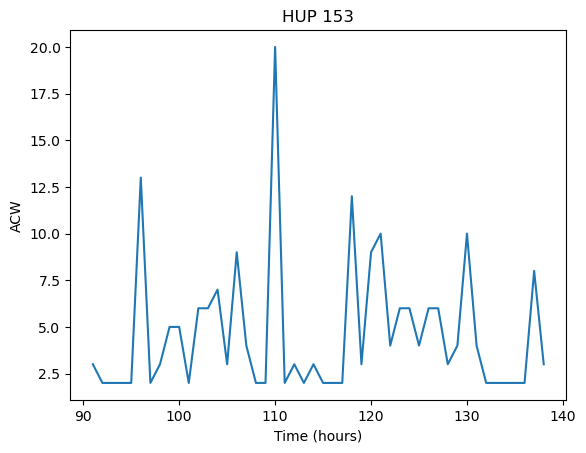

In [15]:
# Plot the awc column over time
plt.plot(hup_153_df["emu_hour"], hup_153_df["acw"])
plt.title("HUP 153")
plt.xlabel("Time (hours)")
plt.ylabel("ACW")
plt.show()

## Teager energy before/after taper

In [ ]:
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 3)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Initialize counters
count = 0
match_expectation_counter = 0

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv")
    )
    before_taper_period, after_taper_period = find_taper_periods(
        hourly_patient_features_df
    )

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[
        hourly_patient_features_df.awake != 0
    ]

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[
        hourly_patient_features_df["num_seizures"] > 0
    ].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Remove seizure rows
    hourly_patient_features_df = hourly_patient_features_df.drop(
        drop_rows, errors="ignore"
    )

    # Get the 'emu_hour' and 'teager_energy' rows within the before and after taper periods
    before_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= before_taper_period[1]),
        "teager_energy",
    ]
    after_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1]),
        "teager_energy",
    ]

    # Remove nan values
    before_taper = before_taper.dropna()
    after_taper = after_taper.dropna()

    # if patient_hup_id == "188":
    #     break

    # Check if the mean of before_taper is larger than the mean of after_taper
    if after_taper.mean() < before_taper.mean():
        match_expectation_counter += 1

    # Create box plots
    row = count // 3
    col = count % 3
    axs[row, col].boxplot(
        [before_taper, after_taper], labels=["Before Taper", "After Taper"]
    )
    axs[row, col].set_title(f"HUP {patient_hup_id} Teager Energy")

    count += 1

# Remove unused subplots
for i in range(count, num_rows * 3):
    fig.delaxes(axs.flatten()[i])

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
print(
    f"The mean of after_taper is smaller than the mean of before_taper for {match_expectation_counter} patients."
)

## Kuramoto order parameter before/after taper

In [ ]:
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 3)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows * 5))

# Initialize counters
count = 0
match_expectation_counter = 0

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv")
    )
    before_taper_period, after_taper_period = find_taper_periods(
        hourly_patient_features_df
    )

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[
        hourly_patient_features_df.awake != 0
    ]

    # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    seizure_rows = hourly_patient_features_df.index[
        hourly_patient_features_df["num_seizures"] > 0
    ].tolist()
    drop_rows = []
    for row in seizure_rows:
        drop_rows.extend(list(range(row - 3, row + 4)))

    # Remove seizure rows
    hourly_patient_features_df = hourly_patient_features_df.drop(
        drop_rows, errors="ignore"
    )

    # Get the 'emu_hour' and 'kuramoto' rows within the before and after taper periods
    before_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= before_taper_period[1]),
        "kuramoto",
    ]
    after_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1]),
        "kuramoto",
    ]

    # Remove nan values
    before_taper = before_taper.dropna()
    after_taper = after_taper.dropna()

    # if patient_hup_id == "188":
    #     break

    # Check if the mean of before_taper is larger than the mean of after_taper
    if after_taper.mean() > before_taper.mean():
        match_expectation_counter += 1

    # Create box plots
    row = count // 3
    col = count % 3
    axs[row, col].boxplot(
        [before_taper, after_taper], labels=["Before Taper", "After Taper"]
    )
    axs[row, col].set_title(f"HUP {patient_hup_id} Kuramoto Parameter")

    count += 1

# Remove unused subplots
for i in range(count, num_rows * 3):
    fig.delaxes(axs.flatten()[i])

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
print(
    f"The mean of after_taper is larger than the mean of before_taper for {match_expectation_counter} patients."
)

## Spike rates before/after taper

In [ ]:
# Calculate the number of rows needed based on the length of patient_hup_ids
num_rows = math.ceil(len(patient_hup_ids) / 5)

# Create a figure with subplots
fig, axs = plt.subplots(num_rows, 5, figsize=(25, num_rows * 5))

# Initialize counters
count = 0
match_expectation_counter = 0

for patient_hup_id in patient_hup_ids:
    # Read in the giant table for this patient
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_DIRECTORY, f"HUP_{patient_hup_id}.csv")
    )
    before_taper_period, after_taper_period = find_taper_periods(
        hourly_patient_features_df
    )

    # If any value in before_taper_period or after_taper_period is nan, skip this patient
    if (
        np.isnan(before_taper_period[0])
        or np.isnan(before_taper_period[1])
        or np.isnan(after_taper_period[0])
        or np.isnan(after_taper_period[1])
    ):
        print(
            f"Patient {patient_hup_id} has nan values in before_taper_period or after_taper_period"
        )
        continue

    # Drop the 'med_lorazepam_raw' column
    hourly_patient_features_df = hourly_patient_features_df.drop(
        "med_lorazepam_raw", axis=1
    )

    # Drop columns that are all zeros
    hourly_patient_features_df = hourly_patient_features_df.loc[
        :, (hourly_patient_features_df != 0).any(axis=0)
    ]

    # Drop rows where 'awake' column is 0
    hourly_patient_features_df = hourly_patient_features_df[
        hourly_patient_features_df.awake != 0
    ]

    # # Find rows where 'num_seizures' is greater than 0 and drop them and three rows before and after
    # seizure_rows = hourly_patient_features_df.index[
    #     hourly_patient_features_df["num_seizures"] > 0
    # ].tolist()
    # drop_rows = []
    # for row in seizure_rows:
    #     drop_rows.extend(list(range(row - 3, row + 4)))

    # # Remove seizure rows
    # hourly_patient_features_df = hourly_patient_features_df.drop(
    #     drop_rows, errors="ignore"
    # )

    # Get the 'emu_hour' and 'spikes_avg_all' rows within the before and after taper periods
    before_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= before_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= before_taper_period[1]),
        "spikes_avg_all",
    ]
    after_taper = hourly_patient_features_df.loc[
        (hourly_patient_features_df["emu_hour"] >= after_taper_period[0])
        & (hourly_patient_features_df["emu_hour"] <= after_taper_period[1]),
        "spikes_avg_all",
    ]

    # Remove nan values
    before_taper = before_taper.dropna()
    after_taper = after_taper.dropna()

    # Check if the mean of before_taper is larger than the mean of after_taper
    if after_taper.mean() > before_taper.mean():
        match_expectation_counter += 1

    # Create box plots
    row = count // 5
    col = count % 5
    axs[row, col].boxplot(
        [before_taper, after_taper], labels=["Before Taper", "After Taper"]
    )
    axs[row, col].set_title(f"HUP {patient_hup_id} Spikes Avg All")

    count += 1

# Remove unused subplots
for i in range(count, num_rows * 5):
    fig.delaxes(axs.flatten()[i])

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

# Print the counter for patients where the mean of before_taper is larger than the mean of after_taper
print(
    f"The mean of after_taper is larger than the mean of before_taper for {match_expectation_counter} patients."
)